In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import ast 
import seaborn as sns

### Histogram for Germination Frame Frequency

In [70]:
def germination_frequency(plots_folder: str, GERMINATION: list, output: int = 1) -> None:
  '''
  output denotes whether to output produced dictionary and plot to jupyter notebooks, shown by default

  creates a dictionary with germination frames as a key, and frequency as a value
  these frequencies are printed in the function
  a histogram plot is also produced
  '''
  germination_frames_list = GERMINATION.apply(lambda x: x.index(1)) #list of germination frames as indices

  #print times frame germination occurs
  frame_counts = Counter(germination_frames_list)
  sorted_frame_counts = sorted(frame_counts.items())
  for frame_number, count in sorted_frame_counts:
      if output == 1:
        print(f"Frame: {frame_number}, Frequency: {count}")
      
  #histogram plot 
  plt.hist(germination_frames_list, bins=289, color='pink', edgecolor='black')
  plt.title("Germination Times")
  plt.xlabel("Frame Number")
  plt.ylabel("Frequency")
  plt.grid()
  plt.savefig(plots_folder + "germination_frequency.jpg")

  if output != 1:
    plt.close()
  return 

### Descriptive Statistics

In [71]:
def group_by_germination(df, feature_str: list[str]):
  ''' 
  Takes in original data frame and list of features to analyze and group together
  returns grouped data
  '''
  data_stats = df.copy()

  for feature in feature_str:
    data_stats[feature] = data_stats[feature].apply(ast.literal_eval)

  data_stats['Germination Frame'] = data_stats['GERMINATION'].apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 
  grouped_data = data_stats.groupby("Germination Frame")

  return grouped_data, data_stats

### Box Plots

In [72]:
def get_max(df, feature: str) -> int:
    data_max = []
    data = df[feature].apply(ast.literal_eval) 
    for row in data:
        data_max.append(max(row))
    return max(data_max)


def box_plot_statistics(germ_time, data, column: str, feature: str, max_feature: int, show_plot = 1):
    aligned_data = [pd.Series(data) for data in data[column]]
    aligned_df = pd.DataFrame(aligned_data)
    melted_aligned_df = aligned_df.melt(var_name='Frame', value_name=feature) #long format
    
    # plotting
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Frame', y=feature, data=melted_aligned_df)
    plt.axvline(x=germ_time, color='red', linestyle='--', label=f'Germination Frame {germ_time}')
    plt.title(f'{feature} Statistics for Spores Germinated at Frame {germ_time}')
    plt.xlabel('Frame')
    plt.xticks([0, 50, 100, 150, 200, 150, 200, 250])
    plt.ylabel(feature)
    plt.ylim(0, max_feature)
    plt.legend()
    plt.savefig(f"{plots_folder}  {feature} _boxplot_ + {germ_time} .jpg")
    
    if show_plot != 1:
        plt.close()

### Spatial

In [73]:
def plot_xy_germinationframe(df, show_plot = 1):  
  plt.figure(figsize=(12, 8))
  #plot
  scatter = plt.scatter(df['X_POSITION'], df['Y_POSITION'], c = df['Germination Frame'], cmap = 'gist_ncar', edgecolor='black', s=100)
  plt.colorbar(scatter, label='Germination Frame')
  plt.xlabel('X')
  plt.ylabel('Y')

  plt.gca().invert_yaxis()
  plt.title('Spores by Germination Frame')
  plt.grid(True)
  plt.savefig(f"{plots_folder}germinationframe_location.jpg")

  if show_plot != 1:
    plt.close()
  ###VALIDATE THIS overlay on tiff

### Signal Summation

In [74]:
def total_signal(df, INTENSITY, GERMINATION):
  germination_totalintensity = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_intensities = INTENSITY[i]
    spore_germination_frame = df.loc[i, "Germination Frame"]
    intensities_before_germination = spore_intensities[0: spore_germination_frame]
    total_intensity = np.sum(intensities_before_germination)
    germination_totalintensity.append(np.array([spore_germination_frame, total_intensity]))

  germination_totalintensity_np = np.array(germination_totalintensity)

  plt.scatter(germination_totalintensity_np[:, 0], germination_totalintensity_np[:, 1])
  plt.xlabel("Germination Frame")
  plt.ylabel("Sum Intensity")
  plt.close()

### Area

Compute ellipse major/ellipse minor before germination and compare to frame 

In [75]:
def majorminor_normalization(df, GERMINATION, ELLIPSE_MINOR, ELLIPSE_MAJOR, show_plots = 1):

  '''
  return 3 np arrays where each row corresponds to a spore, and the first column corresponds to germination frame index and the last column is some measure of ellipse normalization
  '''

  germination_avg_normalized = []
  germination_initial_normalized = []
  germination_last_normalized = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_ellipse_minor = np.array(ELLIPSE_MINOR[i])
    spore_ellipse_major = np.array(ELLIPSE_MAJOR[i])
    spore_relative = spore_ellipse_minor/spore_ellipse_major

    #germination frame index
    spore_germination_frame = df.loc[i, "Germination Frame"]

    #list of minor/major until germination
    relative_before_germination: list = spore_relative[0: spore_germination_frame]

    #plot all minor/major and minor/major in nongerminated frames
    plt.plot(range(len(spore_relative)), spore_relative, color = "lightgrey")
    plt.plot(range(len(relative_before_germination)), relative_before_germination, color = "black")

    # calculate avg, initial(mean first 3), and last measure(mean last 3)
    avg_spore_relative_before_germination = np.mean(relative_before_germination)
    initial_spore_relative_before_germination = np.mean(relative_before_germination[-3: -1])
    last_spore_relative_before_germination = np.mean(relative_before_germination[0: 3])

    #plot horizontal values of mean, intial, and last size 
    plt.plot(range(len(relative_before_germination)), [avg_spore_relative_before_germination]*len(relative_before_germination), label = "Mean Minor/Major", linestyle = "dashdot", color = "blue")
    plt.plot(range(len(relative_before_germination)), [initial_spore_relative_before_germination]*len(relative_before_germination), label = "Initial Minor/Major", linestyle = "dashdot", color = "green")
    plt.plot(range(len(relative_before_germination)), [last_spore_relative_before_germination]*len(relative_before_germination), label = "Last Minor/Major", linestyle = "dashdot", color = "orange")
    plt.legend()


    # add to list
    germination_avg_normalized.append([spore_germination_frame, avg_spore_relative_before_germination])
    germination_initial_normalized.append([spore_germination_frame, initial_spore_relative_before_germination])
    germination_last_normalized.append([spore_germination_frame, last_spore_relative_before_germination])

    if show_plots == 1:
      plt.show()
    plt.clf()
  germination_avg_normalized_np = np.array(germination_avg_normalized)
  germination_initial_normalized_np = np.array(germination_initial_normalized)
  germination_last_normalized_np = np.array(germination_last_normalized)

  return germination_avg_normalized_np, germination_initial_normalized_np, germination_last_normalized_np


    

Scatter Plot of Germination_Frame , Minor/Major 

In [76]:
def scatter_germinationframe_value(germinationframe_value, x_label, y_label, plot_title, color, ylimits, show_plots = 1):
  germinationframes = germinationframe_value[:, 0]
  values = germinationframe_value[:, 1]

  plt.scatter(germinationframes, values, color = color)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(plot_title)
  plt.ylim([0, 1])
  if show_plots == 1:
    plt.show()
    plt.clf()


Correlation between Area before Germination and Germination Frame

In [77]:
def germinationframe_area(df, AREA, GERMINATION):
  avg_germination_area = []
  initial_germination_area = []
  last_germination_area = []

  df['Germination Frame'] = GERMINATION.apply(lambda x: x.index(1)) #get germination frame where first "1" occurs 

  for i in range(len(df)):
    spore_area = AREA[i]
    spore_germination_frame = df.loc[i, "Germination Frame"]
    area_before_germination = spore_area[0: spore_germination_frame]


    avg_area = np.mean(area_before_germination)
    intial_area = np.mean(area_before_germination[0: 3])
    last_area = np.mean(area_before_germination[-3: -1])

    avg_germination_area.append(np.array[spore_germination_frame, avg_area])
    initial_germination_area.append(np.array[spore_germination_frame, initial_area])
    last_germination_area.append(np.array[spore_germination_frame, last_area])

  return np.array(avg_germination_area), np.array(initial_germination_area), np.array(last_germination_area)

### Main 

In [78]:
def Main(csv_path, plots_folder):
  df = pd.read_csv(csv_path)
  print(f"data has columns {list(df.columns)}...")

  # turning model data into lists
  INTENSITY: list[list] = df["INTENSITY"].apply(ast.literal_eval) 
  AREA: list[list] = df["AREA"].apply(ast.literal_eval)
  GERMINATION: list[list] = df["GERMINATION"].apply(ast.literal_eval)
  ELLIPSE_MINOR: list[list] = df["ELLIPSE MINOR"].apply(ast.literal_eval)
  ELLIPSE_MAJOR: list[list] = df["ELLIPSE MAJOR"].apply(ast.literal_eval)

  # germination frequency 
  germination_frequency(plots_folder, GERMINATION, 0)

  # group data by germination frame
  groups, data_stats = group_by_germination(df, ["INTENSITY", "AREA", "GERMINATION"])

  # used for plot limits 
  max_intensity = get_max(df, "INTENSITY")
  max_area = get_max(df, "AREA")

  # iterate through groups
  for name, group in groups: # name is germination frames, and groups is data 
    box_plot_statistics(name, group, "INTENSITY", "Intensity", max_intensity, 0)
    box_plot_statistics(name, group, "AREA", "Area", max_intensity, 0)
    break 

  #plot x, y, and germination frame  
  plot_xy_germinationframe(data_stats, 0)  

  #plot scatter of total signal and germination frame
  total_signal(df, INTENSITY, GERMINATION)

  #plot measures of minor/major 
  germination_avg_normalized_np, germination_initial_normalized_np, germination_last_normalized_np = majorminor_normalization(df, GERMINATION, ELLIPSE_MINOR, ELLIPSE_MAJOR, 0)

  scatter_germinationframe_value(germination_avg_normalized_np, "Germination Frame", "Average Minor/Major", "", "blue", [0,1])
  scatter_germinationframe_value(germination_initial_normalized_np, "Germination Frame", "Initial Minor/Major", "", "green", [0,1])
  scatter_germinationframe_value(germination_last_normalized_np, "Germination Frame", "Last Major/Minor", "", "orange", [0,1])

  avg_area_before_germ_np, initial_area_before_germ_np, last_area_before_germ_np = germinationframe_area(df, AREA, GERMINATION)
  print(avg_area_before_germ_np)
  scatter_germinationframe_value(avg_area_before_germ_np, "Germination Frame", "Average Area before Germination", "", "blue", [0, max_area])


data has columns ['Unnamed: 0', 'INTENSITY', 'AREA', 'GERMINANT EXPOSURE', 'GERMINATION', 'ELLIPSE MINOR', 'ELLIPSE MAJOR', 'X_POSITION', 'Y_POSITION']...


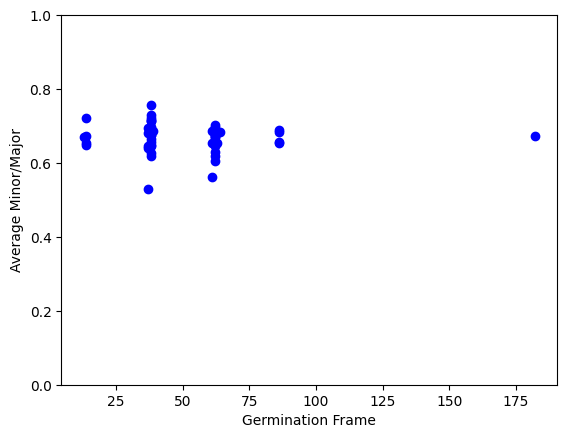

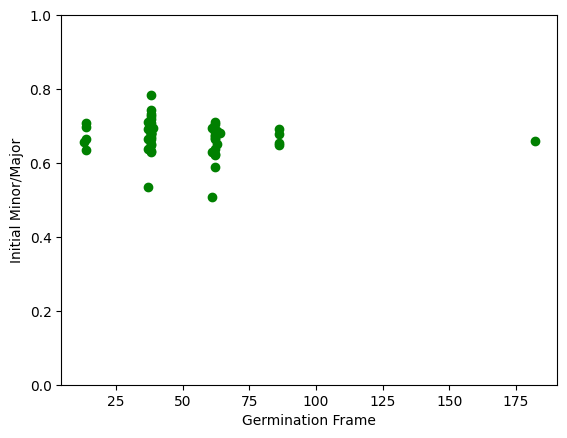

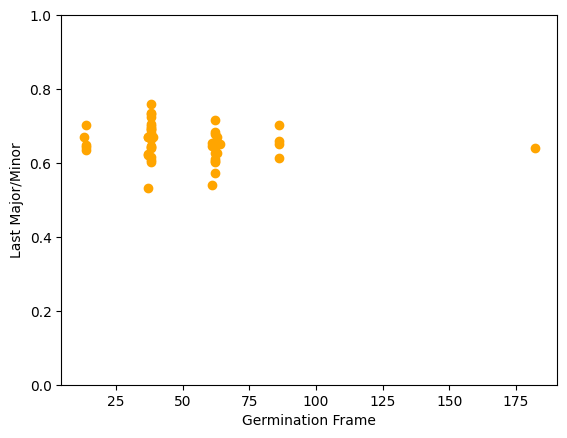

TypeError: 'builtin_function_or_method' object is not subscriptable

<Figure size 640x480 with 0 Axes>

In [79]:
if __name__ == "__main__":
  csv_path = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Model_Data.csv"
  plots_folder = "/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/Plots/"

  Main(csv_path, plots_folder)